In [1]:
import os
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, DummyVecEnv
from stable_baselines3.common.monitor import Monitor, load_results
import matplotlib.pyplot as plt
from src import render_model_gym
from datetime import datetime
import importlib
from src import render_model_gym


from src.definitions import PROJECT_ROOT, enforce_absolute_path
from src import helpers
import src.lucy_classes_v1 as lucy
from src.helpers import generate_paths_monitor_model

importlib.reload(lucy)

<module 'src.lucy_classes_v1' from 'c:\\GitHub\\training-lucy\\src\\lucy_classes_v1.py'>

In [2]:
# Configuration
n_envs = 7
xml_path = enforce_absolute_path("animals/lucy_v2.xml")


def new_vec_env(env: lucy.LucyEnv, monitor_dir: str):
    return make_vec_env(
        env,
        n_envs=n_envs,
        vec_env_cls=SubprocVecEnv,
        monitor_dir=monitor_dir,
    )


print(f"MuJoCo version: {mujoco.__version__}")

# Verify Lucy model loads
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(
    f"Lucy model loaded: {model.nq} qpos dims, {model.nv} qvel dims, {model.nu} actuators"
)
print(f"Observation space will be: {model.nq - 2 + model.nv} dims (qpos[2:] + qvel)")

sim_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")




MuJoCo version: 3.4.0
Lucy model loaded: 53 qpos dims, 44 qvel dims, 38 actuators
Observation space will be: 95 dims (qpos[2:] + qvel)


Episode terminated during frame collection.


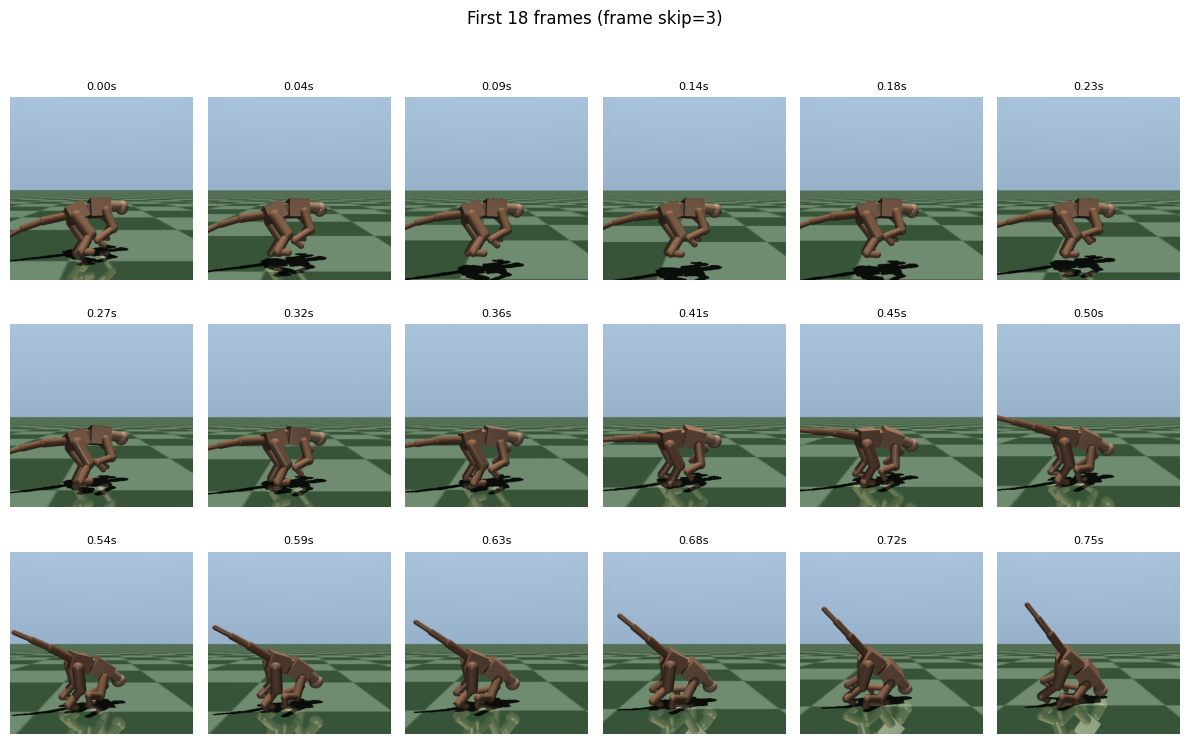

,time,chest_height,forward_velocity,total_height_reward,head_direction_reward,leg_pos_reward,straight_tail_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.045,0.240708,0.218017,9.215039e-05,0.0,0.527551,-0.003639,2.012068,3.830121
2,0.090,0.271562,0.180053,1.500000e+00,0.0,0.525400,-0.083781,3.464731,13.476930
3,0.135,0.283535,0.174002,1.500000e+00,0.0,0.520652,-0.144501,3.486352,24.027558
4,0.180,0.275590,0.157647,1.500000e+00,0.0,0.516298,-0.147259,3.427507,34.610966
5,0.225,0.248364,0.136083,1.947491e-01,0.0,0.511876,-0.029344,2.190058,43.178950
6,0.270,0.212097,0.290577,3.458022e-17,0.0,0.511391,-0.124739,-0.128526,44.929004
7,0.315,0.216995,0.355529,4.634287e-15,0.0,0.521135,-0.060792,1.959157,48.803812
8,0.360,0.211156,0.348193,1.349442e-17,0.0,0.521333,-0.111800,1.905543,54.492976
9,0.405,0.199962,0.346993,1.867325e-22,0.0,0.516376,-0.077250,-0.093948,58.220052


In [5]:
importlib.reload(lucy)

standing_monitor_path, standing_model_path = generate_paths_monitor_model(
    "standing_model"
)


def make_env(render_mode="None", *args, **kwargs):
    return lucy.LucyStandingWrapper(
        lucy.LucyEnv(
            xml_file=xml_path, render_mode=render_mode, max_episode_seconds=10
        ),
    )

standing_attrs = [
    "chest_height",
    "forward_velocity",
    "total_height_reward",
    "head_direction_reward",
    "leg_pos_reward",
    "straight_tail_reward",
]

env = make_env(render_mode="rgb_array")

df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=standing_attrs,
)
plt.show()
df

In [15]:
standing_vec_env = new_vec_env(make_env, standing_monitor_path)

print(f"Created {n_envs} parallel standing environments")
print(f"Logging to: {standing_monitor_path}")

standing_model = PPO(
    policy="MlpPolicy",
    env=standing_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=256,
    n_epochs=4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.02,
    learning_rate=2e-4,
    target_kl=0.03,
    policy_kwargs=dict(
        net_arch=dict(
            pi=[512, 512], vf=[512, 512]
        )
    ),
)

# Train for standing (shorter since simpler task)
STANDING_TIMESTEPS = 2_000_000
print(f"Training standing policy for {STANDING_TIMESTEPS:,} timesteps...")
standing_model.learn(total_timesteps=STANDING_TIMESTEPS)

Created 7 parallel standing environments
Logging to: C:\GitHub\training-lucy\logs\standing_model_2026-01-11_09-04
Using cpu device
Training standing policy for 2,000,000 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 88       |
|    ep_rew_mean     | -67.5    |
| time/              |          |
|    fps             | 3088     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 14336    |
---------------------------------
Early stopping at step 1 due to reaching max kl: 0.05
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 77.6       |
|    ep_rew_mean          | -67.3      |
| time/                   |            |
|    fps                  | 3111       |
|    iterations           | 2          |
|    time_elapsed         | 9          |
|    total_timesteps      | 28672      |
| train/                  |            |
|    approx_k

Stable standing model at: Standing model saved to: `C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-11_09-04`

In [23]:

standing_model.save(standing_model_path)
print(f"Standing model saved to: {standing_model_path}")

Standing model saved to: C:\GitHub\training-lucy\trained_models\walking_model_2026-01-11_09-40


In [24]:
render_model_gym.render_model_gym(standing_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0150s per step
Running simulation at 1.0x speed... Close the window to exit.


c:\GitHub\training-lucy\.venv\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)



Stopped by user


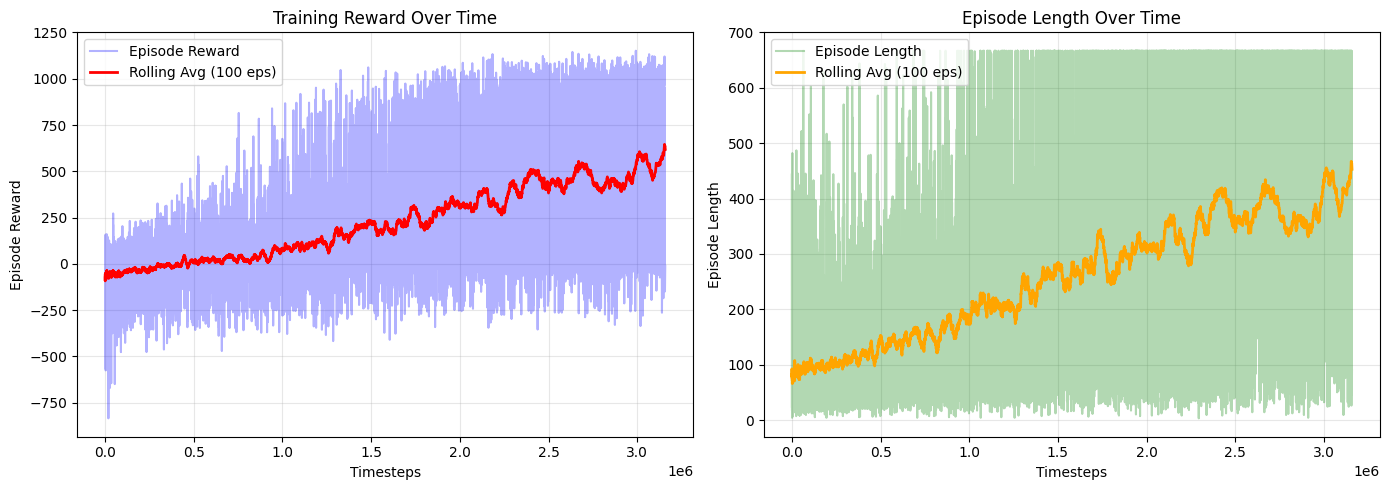

Training Summary:
Total episodes: 11193
Final avg reward (last 100 eps): 618.65
Max reward: 1151.50
  Final avg length (last 100 eps): 453.0


In [25]:
standing_df = load_results(standing_monitor_path)
helpers.plot_training_progress(standing_df)
helpers.print_training_summary(standing_df)

# Walking training

Load stable standing model

In [3]:
standing_model_path = "C:\\GitHub\\training-lucy\\trained_models\\lucy_v2_standing_model_2026-01-11_09-04"

<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
C:\Users\326po\AppData\Local\Temp\ipykernel_17716\515551748.py:6: SyntaxWarning: invalid escape sequence '\G'
  standing_model_path = "C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-11_09-04"


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


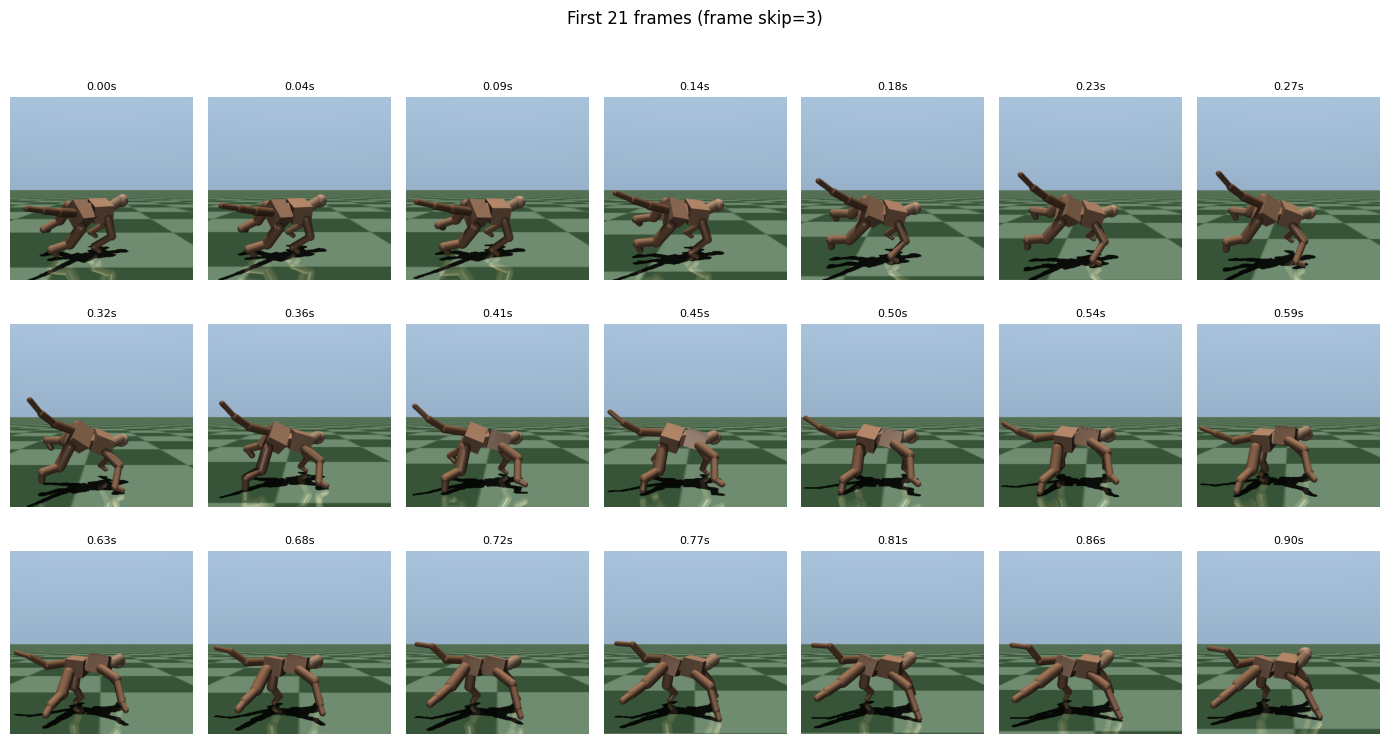

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,height_dict,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
1,0.045,0.195249,0.203211,3.488614,0.0,-0.129968,0.057816,"{'chest': {'height': 0.19524886549830972, 'rew...",4.367634,6.872976
2,0.090,0.192132,0.160752,4.254183,0.0,-0.038072,0.055964,"{'chest': {'height': 0.1921315640273382, 'rewa...",5.169011,24.704982
3,0.135,0.201060,-0.133563,0.714227,0.0,-0.029237,0.053277,"{'chest': {'height': 0.2010599648156164, 'rewa...",1.624206,33.183413
4,0.180,0.207442,-0.347444,-3.110920,0.0,-0.037547,0.052186,"{'chest': {'height': 0.20744168314964415, 'rew...",-2.206516,30.322394
5,0.225,0.211378,-0.441181,-4.587272,0.0,-0.020814,0.052465,"{'chest': {'height': 0.21137827079338475, 'rew...",-3.681180,20.822330
6,0.270,0.209252,-0.551899,-7.136058,0.0,-0.033361,0.053779,"{'chest': {'height': 0.20925169449786635, 'rew...",-6.206623,4.723747
7,0.315,0.199360,-0.573733,-7.875286,0.0,-0.005670,0.055987,"{'chest': {'height': 0.19936045700824134, 'rew...",-6.990505,-17.013199
8,0.360,0.182137,-0.536365,-6.894310,0.0,-0.002567,0.060785,"{'chest': {'height': 0.18213678304353154, 'rew...",-5.970673,-37.331839
9,0.405,0.192607,-0.270256,-2.855177,0.0,-0.008537,0.063063,"{'chest': {'height': 0.1926070213542024, 'rewa...",-1.939286,-41.065814


In [4]:
# Create walking training environment
importlib.reload(lucy)

if "standing_model_path" not in locals():
    print("Loading pre-trained standing model...")
    standing_model_path = "C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-11_09-04"




walking_attrKeys = [
    "chest_height",
    "forward_velocity",
    "forward_reward",
    "gait_reward",
    "stillness_reward",
    "leg_pos_reward",
    "height_dict"
]


walking_log_dir, walking_model_path = generate_paths_monitor_model(
    "walking_model"
)


def make_walking_env(render_mode="None"):
    """Factory function for walking environment."""
    env = lucy.LucyEnv(
        xml_file=xml_path,
        render_mode=render_mode,
        max_episode_seconds=30,
    )
    env = lucy.LucyWalkingWrapper(
        env,
        forward_weight=20,
        fall_threshold=[0.14, 30],
        fall_penalty=-200,
        gait_weight=1,
        body_contact_penalty=-2.0,
        standing_reward_discount_factor=0.3,
    )
    return env


env = make_walking_env(render_mode="rgb_array")
model = PPO.load(standing_model_path, env=env)

# attach env so model.predict works
df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=walking_attrKeys,
    model=model,
)
plt.show()
df

In [ ]:
walking_vec_env = new_vec_env(make_walking_env, walking_log_dir)
print(f"Loading from standing model at: {standing_model_path}")


walking_log_path, walking_model_path = generate_paths_monitor_model(
    f"walking_model"
)

walking_model = PPO.load(standing_model_path, env=walking_vec_env)
walking_model.set_env(walking_vec_env)

walking_model.learn(total_timesteps=3_000_000)

Loading from standing model at: C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-11_09-04
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 277      |
|    ep_rew_mean     | 141      |
| time/              |          |
|    fps             | 2801     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 461         |
|    ep_rew_mean          | 279         |
| time/                   |             |
|    fps                  | 2569        |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.010873149 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|  

In [ ]:
walking_model.save(walking_model_path)

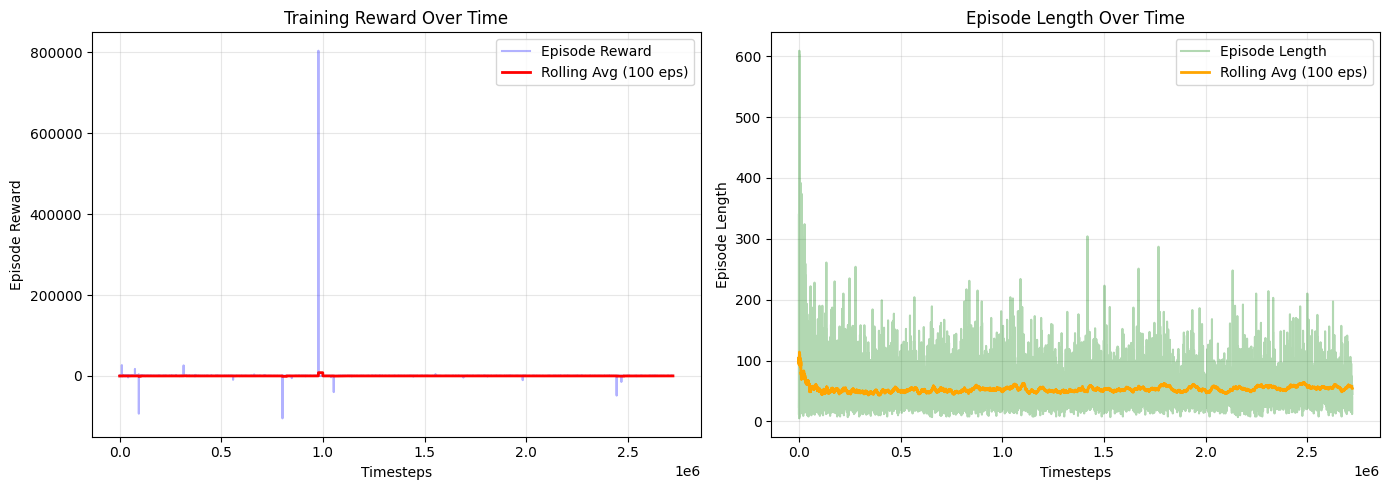

Training Summary:
Total episodes: 13985
Final avg reward (last 100 eps): 195.76
Max reward: 804171.53
  Final avg length (last 100 eps): 54.3


In [ ]:
walking_df = load_results(walking_log_dir)
helpers.plot_training_progress(walking_df)
helpers.print_training_summary(walking_df)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode terminated during frame collection.


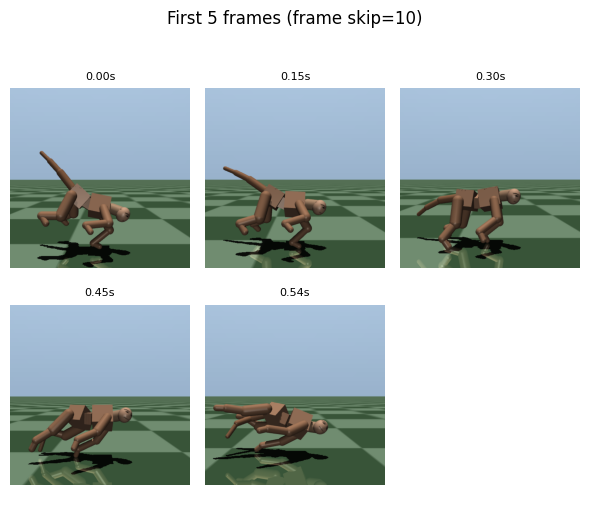

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,height_dict,reward,cum_reward
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
1,0.15,0.187774,-0.138869,-2.073080,0.0,-0.018211,0.060309,"{'chest': {'height': 0.18777390861171797, 'rew...",-1.184786,10.516029
2,0.30,0.204918,0.287470,6.758135,0.0,-0.053094,0.070493,"{'chest': {'height': 0.20491758659709955, 'rew...",7.682616,42.283745
3,0.45,0.184013,0.849525,16.782644,0.0,-0.000963,0.031278,"{'chest': {'height': 0.18401303339977773, 'rew...",17.695442,179.957436
4,0.54,0.139220,0.826194,20.315262,0.0,-0.000304,0.007981,"{'chest': {'height': 0.13921969250926136, 'rew...",-38.805479,237.805017


In [ ]:
model = PPO.load(walking_model_path, env=make_walking_env())
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_walking_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=walking_attrKeys + ["leg_pos_reward"],
    model=model,
)
plt.show()
display(df)

In [11]:
render_model_gym.render_model_gym(walking_model_path, xml_path)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\GitHub\\training-lucy\\trained_models\\walking_model_2026-01-11_01-37.zip'